# Initial analysis for project milestone 2

## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import json
import matplotlib.pyplot as plt
from imdb import Cinemagoer
%matplotlib inline

## Constants

In [2]:
DATA_PATH = 'Data/'
PLOT_SUMMARIES_FILENAME = 'plot_summaries.txt'
MOVIE_METADATA_FILENAME = 'movie.metadata.tsv'
CHARACTER_METADATA_FILENAME = 'character.metadata.tsv'
CHARACTER_TYPES_FILENAME = 'tvtropes.clusters.txt' #character types 
CHARACTER_NAMES_FILENAME ='name.clusters.txt' #unique character names used in at least 2 movies

COLUMN_NAMES_MOVIE_METADATA = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 
                            'Movie box office revenue', 'Movie runtime', 'Movie languages (Freebase ID:name tuples)', 
                            'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)']

COLUMN_NAMES_CHARACTER_METADATA = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name', 'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
COLUMN_NAMES_PLOT_SUMMARIES = ['Wikipedia movie ID', 'Plot summary']




# About the movie metadata

### Import and general analysis

In [3]:
# Reading the movie metadata and displaying the first elements of the dataframe
df_movie_metadata = pd.read_csv(DATA_PATH + MOVIE_METADATA_FILENAME, sep='\t', header=None, names=COLUMN_NAMES_MOVIE_METADATA, index_col=0)
df_movie_metadata.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Simple statistics regarding the dataframe
df_movie_metadata.describe(include="object")

,Freebase movie ID,Movie name,Movie release date,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
count,81741,81741,74839,81741,81741,81741
unique,81741,75478,20389,1817,2124,23817
top,/m/03vyhn,Alice in Wonderland,2006,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
freq,1,17,1011,33748,30300,6851


### Extreme and null values

In [5]:
# Looking for movies with extreme runtime values
print(df_movie_metadata[df_movie_metadata["Movie runtime"] == df_movie_metadata["Movie runtime"].max()][["Movie name", "Movie runtime"]])

                        Movie name  Movie runtime
Wikipedia movie ID                               
10815585            Zero Tolerance      1079281.0


In [6]:
# Looking for the amount of null values in the data set
df_movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81741 entries, 975900 to 12476867
Data columns (total 8 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Freebase movie ID                          81741 non-null  object 
 1   Movie name                                 81741 non-null  object 
 2   Movie release date                         74839 non-null  object 
 3   Movie box office revenue                   8401 non-null   float64
 4   Movie runtime                              61291 non-null  float64
 5   Movie languages (Freebase ID:name tuples)  81741 non-null  object 
 6   Movie countries (Freebase ID:name tuples)  81741 non-null  object 
 7   Movie genres (Freebase ID:name tuples)     81741 non-null  object 
dtypes: float64(2), object(6)
memory usage: 5.6+ MB


We can see that a significant part of the dataset has missing runtime data and we will not consider the data to be perfectly correct as it contains some errors. For instance the movie "Zero Tolerance" is in fact only 94 min long. Also, we can see that most of the dataset has missing box office data. The missing release dates are on a very small subset of the dataset so we will simply ignore those lines when using release dates.<br> 
For the relevant analysis, we will hence be completing the dataset with imdb-data using the Cinemagoer python library.

### Country analysis

In [7]:
print(f"Movies without country: {(df_movie_metadata['Movie countries (Freebase ID:name tuples)']=='{}').sum()}")
country_counts = dict(Counter(itertools.chain.from_iterable(map(lambda x: json.loads(x).values(), df_movie_metadata["Movie countries (Freebase ID:name tuples)"].values.tolist()))))
country_counts = dict(sorted(country_counts.items(), key = lambda x: x[1], reverse = True))

Movies without country: 8154


From the country occurence count, we can consider that the dataset is oriented towards films that have a minimum popularity in the american culture.

### Language analysis

In [8]:
print(f"Movies without language: {(df_movie_metadata['Movie languages (Freebase ID:name tuples)']=='{}').sum()}")
language_counts = dict(Counter(itertools.chain.from_iterable(map(lambda x: json.loads(x).values(), df_movie_metadata["Movie languages (Freebase ID:name tuples)"].values.tolist()))))
language_counts = dict(sorted(language_counts.items(), key = lambda x: x[1], reverse = True))

Movies without language: 13866


The language occurence count confirms our previous consideration from the country counts.

### Movie genre analysis

In [9]:
print(f"Movies without genre: {(df_movie_metadata['Movie genres (Freebase ID:name tuples)']=='{}').sum()}")
genre_counts = dict(Counter(itertools.chain.from_iterable(map(lambda x: json.loads(x).values(), df_movie_metadata["Movie genres (Freebase ID:name tuples)"].values.tolist()))))
genre_counts = dict(sorted(genre_counts.items(), key = lambda x: x[1], reverse = True))

Movies without genre: 2294


In [10]:
# preparation of the dataframes
country_df = pd.DataFrame.from_dict(country_counts, orient="index").reset_index(level=0)
country_df.columns = ["country", "occurency"]

language_df = pd.DataFrame.from_dict(language_counts, orient="index").reset_index(level=0)
language_df.columns = ["language", "occurency"]

genre_df = pd.DataFrame.from_dict(genre_counts, orient="index").reset_index(level=0)
genre_df.columns = ["genre", "occurency"]

In [11]:
country_df

,country,occurency
0,United States of America,34408
1,India,8411
2,United Kingdom,7868
3,France,4395
4,Italy,3163
...,...,...
142,Republic of China,1
143,Macau,1
144,Palestinian Territories,1
145,German Language,1


In [12]:
top_countries = country_df.head(4)
top_languages = language_df.head(4)
top_genres = genre_df.head(10)

other_countries = pd.DataFrame(data = {
    'country' : ['Other countries'],
    'occurency' : [country_df['occurency'][4:].sum()]
})
other_languages = pd.DataFrame(data = {
    'language' : ['Other languages'],
    'occurency' : [language_df['occurency'][4:].sum()]
})
other_genres = pd.DataFrame(data = {
    'genre' : ['Other genre'],
    'occurency' : [genre_df['occurency'][10:].sum()]
})

df1 = pd.concat([top_countries, other_countries])
df2 = pd.concat([top_languages, other_languages])
df3 = pd.concat([top_genres, other_genres])

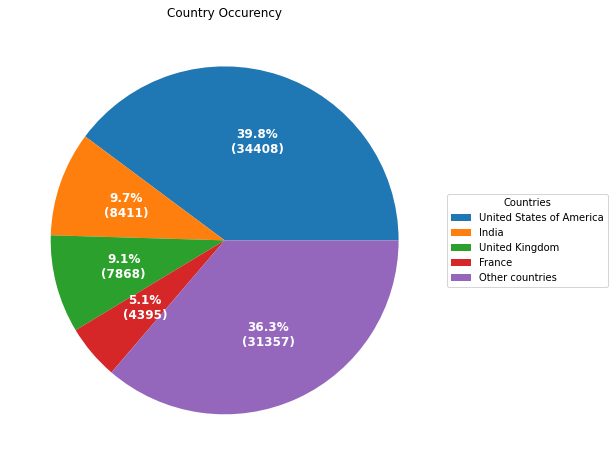

In [13]:
# plot of country occurencies
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

data = df1["occurency"]
labels = df1["country"]
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Country Occurency")

plt.show()

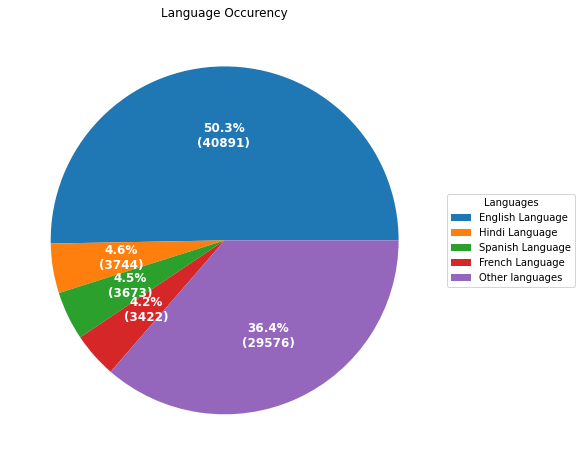

In [14]:
# plot of language occurency
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

data = df2["occurency"]
labels = df2["language"]
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Languages",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Language Occurency")

plt.show()

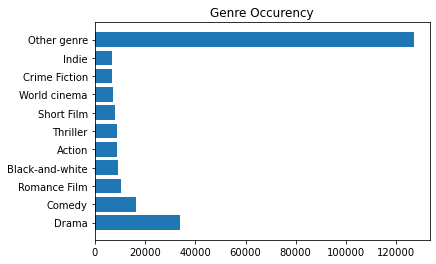

In [15]:
# plot of genre occurency
data = df3["occurency"]
labels = df3["genre"]
plt.barh(df3["genre"], df3["occurency"])

plt.title("Genre Occurency")

plt.show()

### Release date analysis

newest: 2016-06-08, oldest: 1010-12-02
newest: 2013, oldest: 1896


<AxesSubplot:>

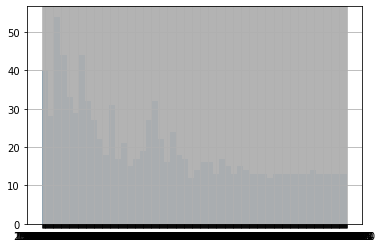

In [16]:
cleaned_dates = pd.to_datetime(df_movie_metadata['Movie release date'].dropna(), errors="ignore")
date_sample = cleaned_dates.sample(n = 1000)
print(f"newest: {cleaned_dates.max()}, oldest: {cleaned_dates.min()}")
print(f"newest: {date_sample.max()}, oldest: {date_sample.min()}")
date_sample.hist(bins = 50)

As a whole, we can see that the data set contains some errors (no movie could have been released in 1010), and that for each feature some data is more or less missing. The majority of the movies represented in the database are american/english dramas and comedies. The sparsity of the data is not an issue per say as we can complete it when needed with the Imdb dataset.

# About the character metadata

### Import and general analysis

In [17]:
df_character_metadata = pd.read_csv(DATA_PATH + CHARACTER_METADATA_FILENAME, sep='\t', header=None, names=COLUMN_NAMES_CHARACTER_METADATA, index_col=0)
df_character_metadata.head()

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [18]:
df_character_metadata.describe(include='object')

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor name,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
count,450669,440674,192794,344524,405060,106058,449441,450669,192804,449854
unique,64330,18476,126629,29494,2,479,134078,450669,183435,135760
top,/m/0cc8620,2008,Doctor,1908-05-30,M,/m/0dryh9k,Mel Blanc,/m/0bgchxw,/m/0h577m2,/m/0c5vh
freq,115,5453,198,791,270257,16351,791,1,146,791


### Null values

In [19]:
print(f"Total size of dataset: {df_character_metadata.shape[0]}")
print("Null data:")
print(df_character_metadata.isnull().sum())

Total size of dataset: 450669
Null data:
Freebase movie ID                       0
Movie release date                   9995
Character name                     257875
Actor date of birth                106145
Actor gender                        45609
Actor height (in meters)           295845
Actor ethnicity (Freebase ID)      344611
Actor name                           1228
Actor age at movie release         158113
Freebase character/actor map ID         0
Freebase character ID              257865
Freebase actor ID                     815
dtype: int64


In [20]:
df_character_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450669 entries, 975900 to 28308153
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Freebase movie ID                450669 non-null  object 
 1   Movie release date               440674 non-null  object 
 2   Character name                   192794 non-null  object 
 3   Actor date of birth              344524 non-null  object 
 4   Actor gender                     405060 non-null  object 
 5   Actor height (in meters)         154824 non-null  float64
 6   Actor ethnicity (Freebase ID)    106058 non-null  object 
 7   Actor name                       449441 non-null  object 
 8   Actor age at movie release       292556 non-null  float64
 9   Freebase character/actor map ID  450669 non-null  object 
 10  Freebase character ID            192804 non-null  object 
 11  Freebase actor ID                449854 non-null  object 


From the above statistics, we can see that for most of the actors the character name, the ethnicity and the height are missing.

### Gender analysis

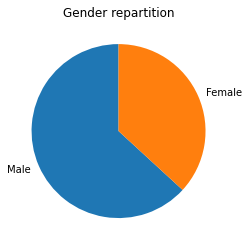

In [21]:
actor_gender = df_character_metadata[["Actor gender", "Freebase actor ID"]].drop_duplicates().dropna()["Actor gender"].value_counts()
plt.pie(actor_gender, labels=["Male", "Female"], startangle = 90)
plt.title("Gender repartition")
plt.show() 

### Actors ethnicity analysis

In [22]:
print(df_character_metadata["Actor ethnicity (Freebase ID)"].dropna().value_counts())
print(df_character_metadata[["Actor ethnicity (Freebase ID)", "Freebase actor ID"]].drop_duplicates().dropna()["Actor ethnicity (Freebase ID)"].value_counts())

/m/0dryh9k    16351
/m/0x67       10159
/m/041rx      10121
/m/02w7gg      6165
/m/033tf_      3857
              ...  
/m/043_z22        1
/m/03x_fq7        1
/m/01hphz         1
/m/033fjj         1
/m/013y54         1
Name: Actor ethnicity (Freebase ID), Length: 479, dtype: int64
/m/0x67       1472
/m/0dryh9k     721
/m/041rx       717
/m/02ctzb      494
/m/02w7gg      385
              ... 
/m/0960kn        1
/m/0h6mqq9       1
/m/0dqrh8        1
/m/07n8wy        1
/m/013y54        1
Name: Actor ethnicity (Freebase ID), Length: 479, dtype: int64


# About the plot summaries

### Import and general analysis

In [23]:
df_plot_summaries = pd.read_csv(DATA_PATH + PLOT_SUMMARIES_FILENAME, sep='\t', header=None, names=COLUMN_NAMES_PLOT_SUMMARIES, index_col=0)
df_plot_summaries.head()

,Plot summary
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [24]:
print(f"Total size of dataset: {df_plot_summaries.shape[0]}")
print("Null data:")
print(df_plot_summaries.isnull().sum())

Total size of dataset: 42303
Null data:
Plot summary    0
dtype: int64


In [25]:
print(f"movies metadata count: {df_movie_metadata.shape[0]}")
print(f"plot summaries count: {df_plot_summaries.shape[0]}")
print(f"intersection count: {df_movie_metadata.join(df_plot_summaries, how = 'inner').shape[0]}")


movies metadata count: 81741
plot summaries count: 42303
intersection count: 42204


# Completing and processing the dataset

For this project we will consider movies with a summary and at least one character and discard the rest for character based analysis.

In [26]:
df_movie_metadata = df_movie_metadata.join(df_plot_summaries, how= 'inner')
df_movie_metadata = df_movie_metadata[df_movie_metadata["Freebase movie ID"].isin(df_character_metadata["Freebase movie ID"])]
print(df_movie_metadata.shape)
df_movie_metadata.head()

(37779, 9)


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Plot summary
Wikipedia movie ID,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


Using the code below we can retrieve data from imdb to complete our dataset when necessary, especially to obtain the box office values.

In [27]:
clean_movie_metadata = []
ia = Cinemagoer()
import random

for index, row in df_movie_metadata.iterrows():
    while True:
        try:
            film = ia.search_movie(row['Movie name'])[0]
            break
        except IndexError:
            pass
        except:
            print(row['Movie name'], "not found")
    if row.isnull().sum() == 0:
        clean_movie_metadata.append([film.movieID, *row.tolist()[1:]])
        print([film.movieID, *row.tolist()[1:3]])
    else:
        try:
            if film["title"].casefold() == row['Movie name'].casefold() and film["year"] == pd.to_datetime(row['Movie release date']).year:
                film = ia.get_movie(film.movieID)
                clean_movie_metadata.append([film.movieID, film["title"], film["year"], int(film["box office"]['Opening Weekend United States'].split()[0][1:].replace(',','')), int(film["runtimes"][0]), row["Movie languages (Freebase ID:name tuples)"], row["Movie countries (Freebase ID:name tuples)"], row["Movie genres (Freebase ID:name tuples)"], row["Plot summary"]])
                print([film.movieID, film["title"], film["year"]])
            else:
                print([film.movieID, film["title"], film["year"]], "mismatch", [row['Movie name'], pd.to_datetime(row['Movie release date']).year])
        except KeyError as e:
            print(film["title"], "missing data", e)
    if random.random() < 0.1:
        break
        
clean_movie_metadata = pd.DataFrame(clean_movie_metadata, columns = ["imdbid", "Movie name", "Movie release year", "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres", "Plot summary"])
clean_movie_metadata.set_index("imdbid")
clean_movie_metadata

['0228333', 'Ghosts of Mars', '2001-08-24']
White of the Eye missing data 'box office'
A Woman in Flames missing data 'box office'
['0963966', "The Sorcerer's Apprentice", 2010] mismatch ["The Sorcerer's Apprentice", 2002]
Little City missing data 'box office'
['0097499', 'Henry V', '1989-11-08']
Aaahh Belinda missing data 'year'
['0033888', 'The Mechanical Monsters', 1941] mismatch ['The Mechanical Monsters', nan]
['0058331', 'Mary Poppins', '1964-08-27']
Die Fahne von Kriwoj Rog missing data 'box office'
['0892904', 'White on Rice', 2009]
Anbu Thozhi missing data 'box office'
['0255819', 'Baby Boy', '2001-06-27']
Bindiya Chamkegi missing data 'box office'
Vandanam missing data 'box office'
['4901338', 'Sakalakala Vallavan', 2015] mismatch ['Anokha Rishta', 1986]
['1849787', 'Karayilekku Oru Kadal Dooram', 2011] mismatch ['Karayilekku Oru Kadal Dooram', 2010]
Siam Sunset missing data 'box office'
['14786996', 'Shrirasthu Shubhamasthu', 2000] mismatch ['Kausthubham', 2010]
Troops missi

,imdbid,Movie name,Movie release year,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot summary
0,0228333,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,0097499,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
2,0058331,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...
3,0892904,White on Rice,2009,8079.0,83.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",Jimmy ([[Hiroshi Watanabe loves dinosaurs and...
4,0255819,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",A young 20-year-old named Jody lives with his...
5,0080801,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...
6,0405393,Rudo y Cursi,2008,11091868.0,103.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico"", ""/m/09c7w0"": ""United S...","{""/m/01z02hx"": ""Sports"", ""/m/07s9rl0"": ""Drama""...","In the fictional farming village of Tlachtlán,..."
7,0097670,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",A Japanese businessman sees a woman being grop...
8,0402230,The Great New Wonderful,2006-06-23,172055.0,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0hj3n0w"": ""Ensembl...",The Great New Wonderful is a series of vignett...
